In [159]:
import sys
sys.path.insert(0, 'src') 
import os
import json
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import pickle
from tqdm import tqdm

TODO:
- Pickle all of the trees that are generated (so we can retroactively do different evals)
- Cache BP embeddings, pass list of embeddings to BERT to generate background distribution
- Increase number of layers to 5
- Zero-shot and few-shot

In [139]:
%reload_ext autoreload
%autoreload 2

In [140]:
import argparse
from tot.methods.bfs import solve
from tot.tasks.bio_name import Bio_Name

In [160]:
args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
# args = argparse.Namespace(backend='gpt-3.5-turbo-1106', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
task = Bio_Name()

positive regulation of intracellular cholesterol transport
dendritic cell antigen processing and presentation
nucleotide-excision repair, DNA incision
oligopeptide transmembrane transport
positive regulation of melanin biosynthetic process
hypomethylation of CpG island
Tie signaling pathway
positive regulation of reciprocal meiotic recombination
positive regulation of viral transcription
RNA (guanine-N7)-methylation
negative regulation of MDA-5 signaling pathway
regulation of protein localization to centrosome
positive regulation of prostaglandin biosynthetic process
tricuspid valve development
neuroblast differentiation
negative regulation of leukocyte adhesion to vascular endothelial cell
negative regulation of natural killer cell differentiation involved in immune response
positive regulation of epithelial to mesenchymal transition involved in endocardial cushion formation
positive regulation of vascular wound healing
regulation of hydrogen peroxide catabolic process
endothelin rece

In [112]:
# import pandas as pd
# filename = 'src/tot/data/gene_sets/go_terms.csv'
# df = pd.read_csv(filename, header=None, encoding='latin1')
# df.dropna(inplace=True)
# df.columns = ['_', '_', 'genes', 'count', 'process']
# df.head()

In [113]:
# x = df['genes'].tolist()
# y = df['process'].tolist()
# with open('src/tot/data/gene_sets/x.txt', 'w') as f:
#     for el in x:
#         f.write(el + '\n')
        
# with open('src/tot/data/gene_sets/y.txt', 'w') as f:
#     for el in y:
#         f.write(el + '\n')

In [135]:
# import pandas as pd
# filename = 'src/tot/data/gene_sets/1000_selected_go_terms.csv'
# df = pd.read_csv(filename, header=0, encoding='latin1')
# print(df.head())
# df.dropna(inplace=True)
# df.columns = ['_', 'genes', 'count', 'process']
# df.head()

           GO                                              Genes  Gene_Count  \
0  GO:0032385                          LDLRAP1 SCP2D1 ANXA2 SCP2           4   
1  GO:0002468  NOD1 HLA-DRA CLEC4A HLA-DRB1 CCL21 NOD2 CCL19 ...          15   
2  GO:0033683                         OGG1 ERCC5 XPA ERCC4 NTHL1           5   
3  GO:0035672  SLC7A11 SLC25A39 SLC26A6 ABCB9 SLC15A4 ABCC5 C...          15   
4  GO:0048023  OPN3 CDH3 ATP7A APPL1 ASIP RAB38 ZEB2 TYRP1 GIPC1           9   

                                    Term_Description  
0  positive regulation of intracellular cholester...  
1  dendritic cell antigen processing and presenta...  
2           nucleotide-excision repair, DNA incision  
3               oligopeptide transmembrane transport  
4  positive regulation of melanin biosynthetic pr...  


,_,genes,count,process
0,GO:0032385,LDLRAP1 SCP2D1 ANXA2 SCP2,4,positive regulation of intracellular cholester...
1,GO:0002468,NOD1 HLA-DRA CLEC4A HLA-DRB1 CCL21 NOD2 CCL19 ...,15,dendritic cell antigen processing and presenta...
2,GO:0033683,OGG1 ERCC5 XPA ERCC4 NTHL1,5,"nucleotide-excision repair, DNA incision"
3,GO:0035672,SLC7A11 SLC25A39 SLC26A6 ABCB9 SLC15A4 ABCC5 C...,15,oligopeptide transmembrane transport
4,GO:0048023,OPN3 CDH3 ATP7A APPL1 ASIP RAB38 ZEB2 TYRP1 GIPC1,9,positive regulation of melanin biosynthetic pr...


In [137]:
# x = df['genes'].tolist()
# y = df['process'].tolist()
# with open('src/tot/data/gene_sets/x_eval.txt', 'w') as f:
#     for el in x:
#         f.write(el + '\n')
        
# with open('src/tot/data/gene_sets/y_eval.txt', 'w') as f:
#     for el in y:
#         f.write(el + '\n')

In [161]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

SapBERT_tokenizer = AutoTokenizer.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
SapBERT_model = AutoModel.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

In [162]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [163]:
def getSentenceEmbedding(sentence, tokenizer, model):
    # Tokenize sentences
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        
    # Perform pooling. In this case, mean pooling.
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    
    return sentence_embedding

In [164]:
# filename = 'src/tot/data/gene_sets/go_terms.csv'
# all_terms_df = pd.read_csv(filename, header=None, encoding='latin1')
# all_terms_df.dropna(inplace=True)
# all_terms_df.columns = ['_', '_', 'genes', 'count', 'process']

In [146]:
# # get embedding for all biological processes
# from tqdm import tqdm
# all_go_terms = all_terms_df['process'].unique().tolist()
# all_go_terms_embeddings_dict = {}
# for term in tqdm(all_go_terms):
#     all_go_terms_embeddings_dict[term] = getSentenceEmbedding(term, SapBERT_tokenizer, SapBERT_model).numpy()

In [147]:
# import pickle
# with open('src/tot/data/gene_sets/all_go_terms_embeddings_dict.pkl', 'wb') as f:
#     pickle.dump(all_go_terms_embeddings_dict, f)

In [165]:
all_go_terms_embeddings_dict = pickle.load(open('src/tot/data/gene_sets/all_go_terms_embeddings_dict.pkl', 'rb'))

In [149]:
# def getSentenceSimilarity(sentence1, sentence2, tokenizer, model, simMetric):
#     if sentence1 in embeddings_dict.keys():
#         sentence1_embedding = embeddings_dict[sentence1]
#     else:
#         sentence1_embedding = getSentenceEmbedding(sentence1, tokenizer, model)
#     if sentence2 not in embeddings_dict.keys():
#         sentence2_embedding = embeddings_dict[sentence2]
#     else:
#         sentence2_embedding = getSentenceEmbedding(sentence2, tokenizer, model)
    
#     if simMetric == "cosine_similarity":
#         sentenceSim = cosine_similarity(sentence1_embedding, sentence2_embedding)[0][0]
#     # ToDo: add other simMetrics
#     #elif simMetric == "cosine_similarity_primitive": # use primitive operations
#    #     sentenceSim = np.dot(sentence1_embedding, sentence2_embedding)/(norm(sentence1_embedding)*norm(sentence2_embedding))
    
#     return sentenceSim, sentence1_embedding, sentence2_embedding

In [150]:
# def similarity_score(x, y):
#     return getSentenceSimilarity(x, y, SapBERT_tokenizer, SapBERT_model, "cosine_similarity")[0]

In [176]:
def similarity_score(pred, label):
    pred_embedding = getSentenceEmbedding(pred, SapBERT_tokenizer, SapBERT_model)
    label_embedding = all_go_terms_embeddings_dict[label]
    similarity_score = cosine_similarity(pred_embedding, label_embedding)[0][0]
    return similarity_score

def similarity_percentile(similarity_score, pred):
    pred_embedding = getSentenceEmbedding(pred, SapBERT_tokenizer, SapBERT_model)
    null_dist = []
    for term in all_go_terms_embeddings_dict.keys():
        term_embedding = all_go_terms_embeddings_dict[term]
        sentenceSim = cosine_similarity(pred_embedding, term_embedding)[0][0]
        null_dist.append(sentenceSim)
    # get similarity percentile
    null_dist = np.array(null_dist)
    # return the fraction of scores that are smaller than the candidate
    percentile = (null_dist < similarity_score).mean()
    return percentile

null distribution of sim scores: random assignment of different pairs of labels
compare the sim score of the answer to true label to null distribution -> p value (sim score greater than 98% of random sim scores for example)
500/1000 had p > .98

In [167]:
def test_example(args, task, idx):
    label = task.get_label(idx)
    final_answer, ys, steps, trie = solve(args, task, idx)
    return final_answer, ys, steps, trie, label


In [168]:
def get_all_candidate_bio_processes(steps):
    candidate_processes = []
    step_count = 0
    for step in steps['steps'][:-1]:
        step_count += 1
        new_ys = [json.loads(step['new_ys'][i]) for i in range(len(step['new_ys']))]
        new_bio_processes = [y['Biological Process'] for y in new_ys]
        candidate_processes.extend(new_bio_processes)
    candidate_processes = list(set(candidate_processes))
    return candidate_processes
    

In [174]:
def get_best_candidate_bio_process(candidate_processes, label):
    scores = [similarity_score(candidate_process, label) for candidate_process in candidate_processes]
    best_candidate_process = candidate_processes[np.argmax(scores)]
    return best_candidate_process, np.max(scores)

In [170]:
from tot.models import *
gpt = partial(gpt, model=args.backend, temperature=args.temperature)
def get_gpt_similarity_score(process1, process2):
    system_message, user_message = task.similarity_prompt_wrap(process1, process2)
    response = gpt(system_message, user_message)
    similarity_score = task.unwrap_similarity(response)
    return similarity_score

In [171]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [195]:
def test_example_wrap(idx, task):
    final_answer, ys, steps, trie, label = test_example(args, task, idx)
    candidate_processes = get_all_candidate_bio_processes(steps)
    best_candidate_process, best_candidate_similarity_score = get_best_candidate_bio_process(candidate_processes, label)
    final_answer_similarity_score = similarity_score(final_answer, label)
    final_answer_similarity_quantile = similarity_percentile(final_answer_similarity_score, final_answer)
    best_candidate_similarity_quantile = similarity_percentile(best_candidate_similarity_score, best_candidate_process)
    print('Index:', idx)
    print('Final answer:', final_answer)
    print('True answer:', label.strip())
    print('Final answer similarity score:', similarity_score(final_answer, label))
    print('Best candidate process:', best_candidate_process)
    print('Best candidate similarity score:', best_candidate_similarity_score)
    print('Final Answer Similarity Quantile:', final_answer_similarity_quantile)
    print('Best Candidate Similarity Quantile:', best_candidate_similarity_quantile)
    print()
    return {'index': idx, 'final answer': final_answer, 'ys': ys, 'steps': steps, 'label': label, 'final answer similarity score': final_answer_similarity_score,'best candidate process': best_candidate_process, 'best similarity score': best_candidate_similarity_score,
            'final answer similarity quantile': final_answer_similarity_quantile, 'best candidate similarity quantile': best_candidate_similarity_quantile, 'trie': trie}

In [200]:
save_file = 'results/eval_tot_0_99.pkl'
eval_indices = range(0, 100)
results = []
for idx in tqdm(eval_indices):
    start = time.time()
    results.append(test_example_wrap(idx, task_tot))
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)
    print('Time taken:', time.time() - start)
    print()

  1%|          | 1/100 [00:32<53:37, 32.50s/it]

Index: 0
Final answer: Lipid metabolic process
True answer: positive regulation of intracellular cholesterol transport
Final answer similarity score: 0.27524304
Best candidate process: Endocytosis
Best candidate similarity score: 0.30695364
Final Answer Similarity Quantile: 0.6187981005403635
Best Candidate Similarity Quantile: 0.47363681021778287

Time taken: 32.50169777870178



  1%|          | 1/100 [00:59<1:38:25, 59.66s/it]


KeyboardInterrupt: 

In [206]:
def eval_100(task, save_filename):
    eval_indices = range(0, 50)
    results = []
    for idx in tqdm(eval_indices):
        start = time.time()
        results.append(test_example_wrap(idx, task))
        with open(save_filename, 'wb') as f:
            pickle.dump(results, f)
        print('Time taken:', time.time() - start)
        print()

In [207]:
args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
# args = argparse.Namespace(backend='gpt-3.5-turbo-1106', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
task_tot = Bio_Name()
save_file = 'results/eval_tot_0_99.pkl'
eval_100(task_tot, save_file)

  0%|          | 0/50 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [204]:
args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, \
                          prompt_sample=None, method_generate='sample_bionames', \
                          method_evaluate='multi_voters', method_select='greedy', n_generate_sample=3, \
                          n_evaluate_sample=2, n_select_sample=2, \
                          source='GO:BP', bio_type="Biological Process",filter_method='sim', filter_size=5, voting_setting=None,\
                          
                         )
            
task_gprofiler = Bio_Name()
save_file = 'results/eval_gprofiler_0_99.pkl'
eval_100(task_gprofiler, save_file)

  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [205]:
import argparse

medagents_config = {'model_name':'gpt-4-1106-preview', \
                    'method':'syn_verif', \
                    'max_attempt_vote':3,\
                    'ans_num':2,\
                    'numerical':True
                   }

tot_config = {'backend':'gpt-4-1106-preview', 'temperature':0.7, 'task':'bio_name', 'naive_run':False, \
              'prompt_sample':None, 'method_generate':'sample_bionames', \
              'method_evaluate':'medagents_w_tools', 'method_select':'greedy', \
              'n_generate_sample':3, 'n_evaluate_sample':2, 'n_select_sample':2, \
              'source':'GO:BP', 'bio_type':"Biological Process",'filter_method':'sim', \
              'filter_size':5, 'voting_setting':None}

args_config = {**medagents_config, **tot_config}
args = argparse.Namespace(**args_config)
task_medagents_gprofiler = Bio_Name()
save_file = 'results/eval_medagents_gprofiler_0_99.pkl'
eval_100(task_medagents_gprofiler, save_file)

  0%|          | 0/100 [00:00<?, ?it/s]

Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  1.0653409957885742
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  1.3909640312194824
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  23.81737208366394
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  19.367439031600952
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  34.58527684211731
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  26.419435024261475
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  13.880903720855713
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  25.659600019454956
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  14.852896928787231
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  47.09683299064636
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  1.97571492

  1%|          | 1/100 [04:17<7:04:39, 257.37s/it]

Index: 0
Final answer: Lipid metabolic process
True answer: positive regulation of intracellular cholesterol transport
Final answer similarity score: 0.27524304
Best candidate process: Lipid metabolic process
Best candidate similarity score: 0.27524304
Final Answer Similarity Quantile: 0.6187981005403635
Best Candidate Similarity Quantile: 0.6187981005403635

Time taken: 257.3694851398468



  1%|          | 1/100 [04:36<7:36:47, 276.84s/it]


KeyboardInterrupt: 

In [29]:
final_ans_count = 0
best_candidate_count = 0
for res in results:
    final_ans_count += int(res['final answer similarity quantile'] >= .98)
    best_candidate_count += int(res['best candidate similarity quantile'] >= .98)

In [30]:
final_ans_count, best_candidate_count

(8, 15)

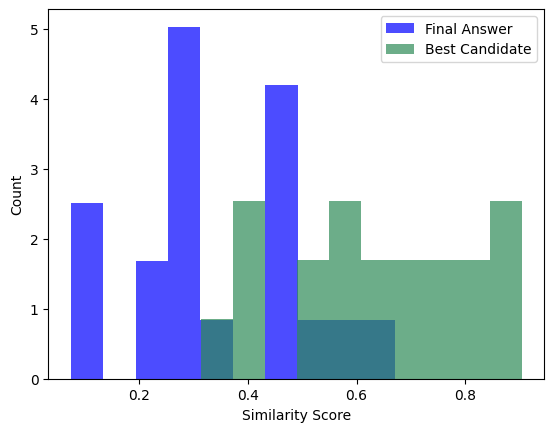

In [34]:
final_ans_scores = []
best_candidate_scores = []
for res in results:
    final_ans_scores.append(res['final answer similarity score'])
    best_candidate_scores.append(res['best similarity score'])

import matplotlib.pyplot as plt
plt.hist(final_ans_scores, alpha=0.7, label='Final Answer', color='blue', density=True)
plt.hist(best_candidate_scores, alpha=0.7, label='Best Candidate', color='seagreen', density=True)
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.legend(['Final Answer', 'Best Candidate'])
plt.show()